In [1]:
import os
import pickle
import numpy as np

In [14]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Code type using for Pytorch: {device}")

Code type using for Pytorch: cuda


## Reload trained model

In [15]:
import torchvision.transforms as transforms

In [10]:
from models import CNNEncoder, RNNModel, collate_function
from preprocesses import TokenIndex

In [17]:
with open('token_index.pkl', 'rb') as file:
    token2index = pickle.load(file)

token2index

In [55]:
index2token = token2index.idx2Token

In [30]:
encoder = CNNEncoder(256).eval().to(device)
decoder = RNNModel(256, 512, len(token2index), 1).eval().to(device)

# Load the trained model parameters
encoder.load_state_dict(torch.load('models/encoder.ckpt'))
decoder.load_state_dict(torch.load('models/decoder.ckpt'))

/tmp/ipykernel_17729/652534708.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load('models/encoder.ckpt'))
/tmp/ipykernel_17729/652534708.

<All keys matched successfully>

In [31]:
# transformation pipeline 

# exclude Random Crop  & Random Flip

transform_pipeline = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

### read in photo from validation set

In [32]:
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

In [33]:
from preprocesses import reshape_image

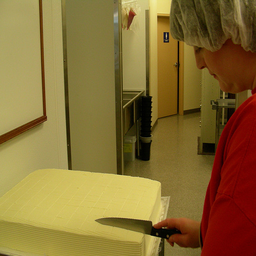

In [34]:
img_path = os.path.join("data/val2014", "COCO_val2014_000000522418.jpg")
img = Image.open(img_path)
img_reshaped = reshape_image(img, (256, 256))
img_reshaped

In [35]:
img_pt = transform_pipeline(img_reshaped).unsqueeze(0).to(device)

In [40]:
encode_embed = encoder(img_pt)
encode_embed.shape

torch.Size([1, 256])

In [59]:
decode_idxs = decoder.sample(encode_embed)
decode_idxs

tensor([[  2,   4,  99, 131, 225,  78,   4, 870,  22,   4, 784,  19,   3,   3,
           3,   3,  19,   3,   3,   3]], device='cuda:0')

In [60]:
def indexesToCaption(idxs_pt, index2Token):
    idxs = idxs_pt[0].cpu().numpy()
    tokens = []
    for idx in idxs:
        t = index2Token.get(idx, '<unk>')
        if t=='<end>':
            break
        if t!='<start>':
            tokens.append(t)
    return " ".join(tokens)

In [61]:
caption = indexesToCaption(decode_idxs, index2token)
print(caption)

a person is sitting in a chair with a laptop .


### Load random photo from internet to test

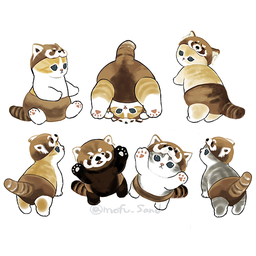

In [63]:
img = Image.open('mofusand.jpg')
img_reshaped = reshape_image(img, (256, 256))
img_reshaped

In [64]:
img_pt = transform_pipeline(img_reshaped).unsqueeze(0).to(device)

encode_embed = encoder(img_pt)
decode_idxs = decoder.sample(encode_embed)

caption = indexesToCaption(decode_idxs, index2token)
print(caption)

a group of stuffed animals hanging from a wall .
